# Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) seeks to group data into clusters based on their properties and then allow us to predict which cluster a new member belongs.

We'll use a dataset generator that is part of [scikit-learn](https://scikit-learn.org/stable/index.html) called [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).  This generates data that falls into 2 different sets with a shape that looks like half-moons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [41]:
def generate_data():
    xvec, val = datasets.make_moons(200, noise=0.2)

    # encode the output to be 2 elements
    x = []
    y = []
    for xv, vv in zip(xvec, val):
        x.append(np.array(xv))
        if vv == 0:
            y.append(np.array([1, 0.0]))
        else:
            y.append(np.array([0.0, 1]))

    return np.array(x), np.array(y)

In [42]:
def plot_data(x, v):
    xpt = [q[0] for q in x]
    ypt = [q[1] for q in x]

    val = [np.argmax(q) for q in v]

    fig, ax = plt.subplots()
    ax.scatter(xpt, ypt, s=40, c=val, cmap="viridis")
    ax.set_aspect("equal")
    return fig

In [43]:
x, y = generate_data()

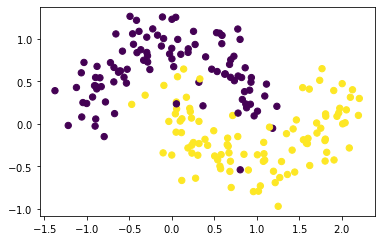

In [44]:
fig = plot_data(x, y)

We want to partition this domain into 2 regions, such that when we come in with a new point, we know which group it belongs to.

First we setup and train our network

In [45]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop

In [46]:
model = Sequential()
model.add(Dense(100, input_dim=2))
model.add(Activation("sigmoid"))
model.add(Dense(2))
model.add(Activation("softmax"))

In [47]:
rms = RMSprop()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

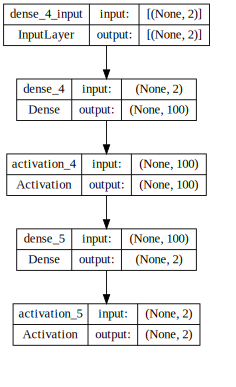

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [49]:
epochs = 20
model.fit(x, y, epochs=epochs)

Epoch 1/20
7/7 [==============================] - 0s 1ms/step - loss: 0.7097 - accuracy: 0.5000
Epoch 2/20
7/7 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.6950
Epoch 3/20
7/7 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.7600
Epoch 4/20
7/7 [==============================] - 0s 1ms/step - loss: 0.6331 - accuracy: 0.7750
Epoch 5/20
7/7 [==============================] - 0s 1ms/step - loss: 0.6216 - accuracy: 0.8000
Epoch 6/20
7/7 [==============================] - 0s 1ms/step - loss: 0.6108 - accuracy: 0.8050
Epoch 7/20
7/7 [==============================] - 0s 1ms/step - loss: 0.5984 - accuracy: 0.7950
Epoch 8/20
7/7 [==============================] - 0s 899us/step - loss: 0.5882 - accuracy: 0.8000
Epoch 9/20
7/7 [==============================] - 0s 895us/step - loss: 0.5739 - accuracy: 0.8300
Epoch 10/20
7/7 [==============================] - 0s 826us/step - loss: 0.5627 - accuracy: 0.8150
Epoch 11/20
7/7 [================

In [50]:
x[0]

array([0.11976117, 0.06020796])

In [51]:
y[0]

array([0., 1.])

In [52]:
x.shape

(200, 2)

Let's plot the partitioning

In [53]:
M = 64
N = 64
domain = np.zeros((M, N))

xmin = ymin = -2.0
xmax = ymax = 2.0

xpt = np.linspace(-2.0, 2.0, M)
ypt = np.linspace(-2.0, 2.0, N)

In [54]:
for m in range(M):
    print(m)
    for n in range(N):
        res = model.predict(np.array([xpt[m], ypt[n]]).reshape(1, 2),
                            verbose=0)
        domain[m, n] = np.argmax(res)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


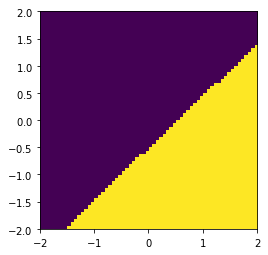

In [55]:
fig, ax = plt.subplots()
ax.imshow(domain.T, origin="lower", extent=[xmin, xmax, ymin, ymax])

In [16]:
model.predict(x[0].reshape(1, 2))

1/1 [==============================] - 0s 39ms/step


array([[0.8890656 , 0.11093439]], dtype=float32)